In [1]:
%matplotlib notebook
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import mahotas as mh
from colicoords import iter_subplots
import numpy as np
from symfit import Parameter, Variable, Fit, Model, exp
import os

In [2]:
def generate_background(image, median_kernel=11, gaussian_kernel=11, dtype=int):
    assert median_kernel % 2 == 1
    assert image.ndim == 2
    sp_m = medfilt(image, kernel_size=median_kernel)

    #fill corners
    cz = int((median_kernel - 1) / 2)
    sp_m[:cz, :cz] = sp_m[cz, cz]
    sp_m[:cz, -cz:] = sp_m[cz, -cz]
    sp_m[-cz:, -cz:] = sp_m[-cz, -cz]
    sp_m[-cz:, :cz] = sp_m[-cz, cz]

    gf = mh.gaussian_filter(sp_m, gaussian_kernel)

    return gf.astype(dtype)

In [3]:
import symfit
symfit.__version__

'0.5.1'

In [4]:
import colicoords
colicoords.__version__

'0.0.0'

In [15]:
data_dir = r'H:\data\t3ss\20191009_c41_eyfp-escv_AHT30_agarose_medium_repeats' 
#output_dir = r'F:\_processed_big\t3ss\20191002_deltaescv_c41_eyfp-escv_repeat_03'  #moved here
output_dir = r'E:\20191009_c41_eyfp-escv_AHT30_agarose_medium_repeats'  #tempdir, fasterspeed

In [5]:
#df_dir = r'F:\data\t3ss\20191002_deltaescv_c41_eyfp-escv_repeat_03'

In [8]:
dfg100 = tifffile.imread(os.path.join(data_dir, 'Image', 'dark_g100.tif'))
dfg500 = tifffile.imread(os.path.join(data_dir, 'Image', 'dark_g500.tif'))
dfg100.mean() - dfg500.mean()

93.47394943237305

In [21]:
c41_02_bf = tifffile.imread(os.path.join(data_dir, 'c41_01', '_BF_140_.tif'))
c41_03_bf = tifffile.imread(os.path.join(data_dir, 'c41_02', '_BF_140_.tif'))

In [10]:
c41_02_bf.shape, c41_03_bf.shape

((1400, 512, 512), (1400, 512, 512))

<IPython.core.display.Javascript object>


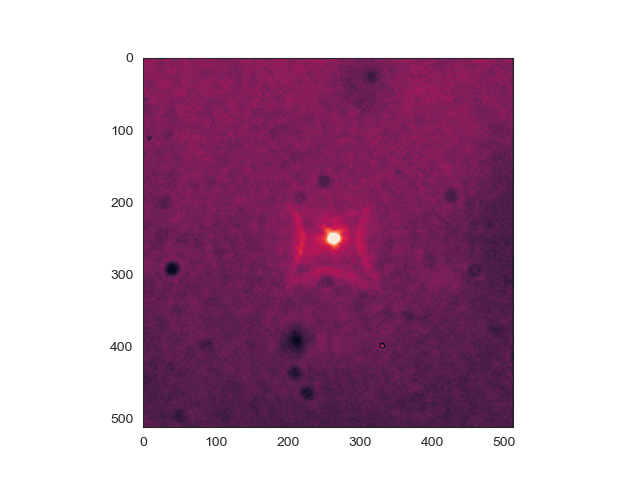

In [11]:
c41_02_median = np.median(c41_02_bf, axis=0)
c41_02_median.shape
plt.figure()
plt.imshow(c41_02_median)

In [12]:
bf_flat_c41_02 = (c41_02_bf - dfg100) / (c41_02_median - dfg100)

<IPython.core.display.Javascript object>


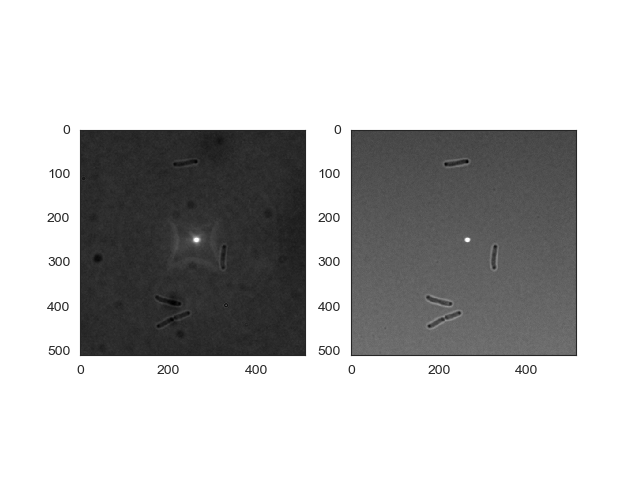

In [13]:
fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(c41_02_bf, cmap='gray')
ax2.iter_imshow(bf_flat_c41_02, cmap='gray')
fig.display()

In [16]:
np.save(os.path.join(output_dir, 'BF_C41_01_flat.npy'), bf_flat_c41_02)

In [17]:
bf_flat_c41_02.shape

(1400, 512, 512)

<IPython.core.display.Javascript object>


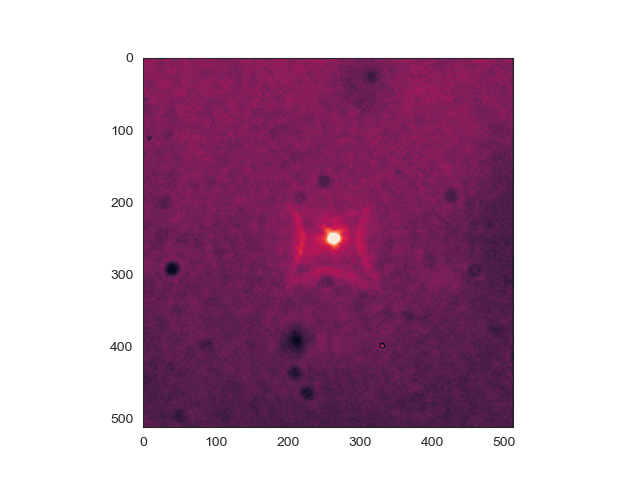

In [18]:
c41_03_median = np.median(c41_03_bf, axis=0)
c41_03_median.shape
plt.figure()
plt.imshow(c41_03_median)

In [22]:
c41_03_bf_flat = (c41_03_bf - dfg100) / (c41_03_median - dfg100)

<IPython.core.display.Javascript object>


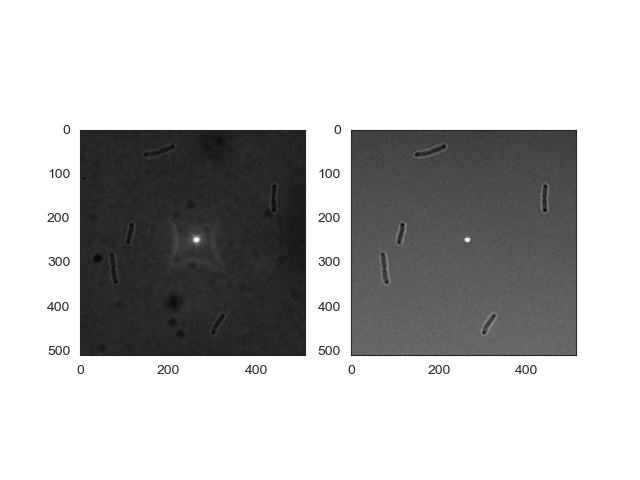

In [23]:
fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(c41_03_bf, cmap='gray')
ax2.iter_imshow(c41_03_bf_flat, cmap='gray')
fig.display()

In [24]:
np.save(os.path.join(output_dir, 'BF_C41_02_flat.npy'), c41_03_bf_flat)

In [25]:
c41_03_bf_flat.shape

(1600, 512, 512)

## Beamprofile

In [26]:
images = ['Image_027.tif', 'Image_028.tif', 'Image_029.tif', 'Image_030.tif', 'Image_031.tif', 'Image_032.tif', 'Image_033.tif']
bps = [tifffile.imread(os.path.join(data_dir, 'Image', f)) for f in images]

In [27]:
bp = np.stack(bps)
bp.shape

(7, 512, 512)

In [28]:
abp.shape

(7, 512, 512)

<IPython.core.display.Javascript object>


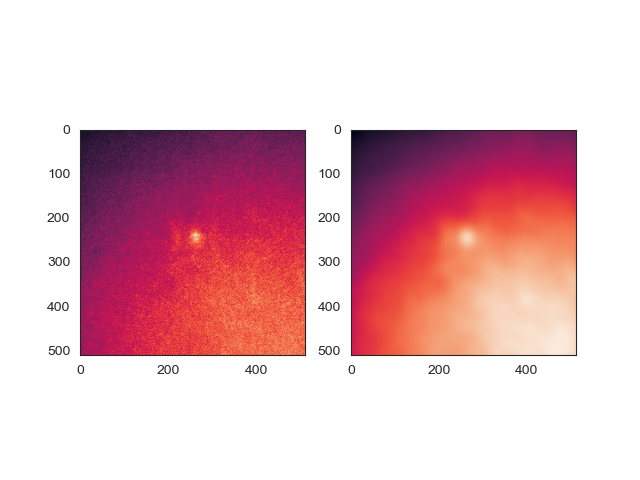

In [29]:
smoothed = generate_background(np.mean(bp, axis=0))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.mean(bp, axis=0))
ax2.imshow(smoothed)

In [32]:
def model_gauss2d(a_val, x_mu_val, y_mu_val, sig_x_val, sig_y_val, base, has_base=True):
    a = Parameter(name='a', value=a_val)
    sig_x = Parameter(name='sig_x', value=sig_x_val)
    sig_y = Parameter(name='sig_y', value=sig_y_val)
    x_mu = Parameter(name='x_mu', value=x_mu_val)
    y_mu = Parameter(name='y_mu', value=y_mu_val)
    if has_base:
        b = Parameter(name='b', value=base)
    else:
        b = base
    x_var = Variable(name='x_var')
    y_var = Variable(name='y_var')
    z_var = Variable(name='z_var')

    model = {z_var: a*exp(-( ((x_var-x_mu)**2/(2*sig_x**2)) + ((y_var-y_mu)**2 / (2*sig_y**2)) )) + b}
    return model

def fit_gauss2d(arr):
    Y, X = np.indices(arr.shape)

    total = arr.sum()
    x = (X*arr).sum()/total
    y = (Y*arr).sum()/total
    col = arr[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = arr[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    base = 1800
    
    
    idx = np.argmax(arr)
    y_mu, x_mu = np.unravel_index(idx, arr.shape)

    print(arr.max(), x_mu, y_mu, width_x, width_y, base)
    model = model_gauss2d(arr.max(), x_mu, y_mu, width_x, width_y, base, has_base=True)

    fit = Fit(model, z_var=arr, x_var=X, y_var=Y)
    return fit.execute(), fit.model

In [33]:
res, model = fit_gauss2d(smoothed)

19018 466 498 315.66538179845816 299.6333668832311 1800


In [34]:
X, Y = np.indices(smoothed.shape)

In [35]:
z = model(x_var=X, y_var=Y, **res.params)[0]

<IPython.core.display.Javascript object>


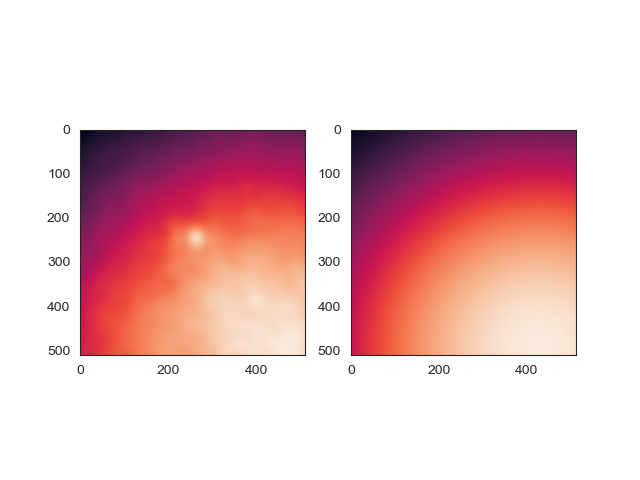

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(smoothed)
ax2.imshow(z.T)

<IPython.core.display.Javascript object>


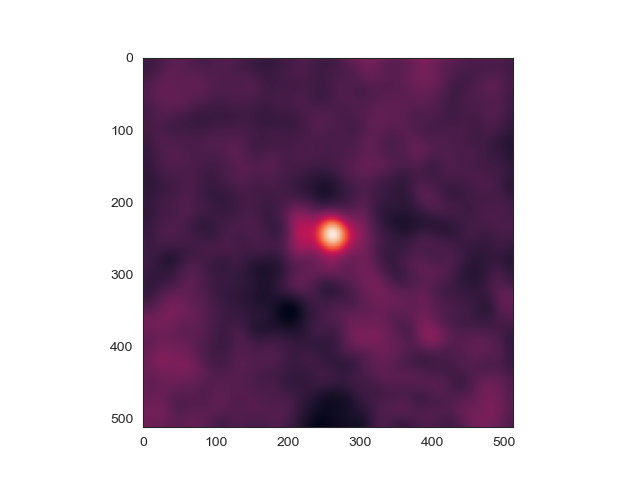

In [38]:
plt.figure()
plt.imshow(smoothed - z.T)

In [39]:
bp_final = z.T - dfg100
bp_final /= bp_final.max()
bp_final.max()

1.0

<IPython.core.display.Javascript object>


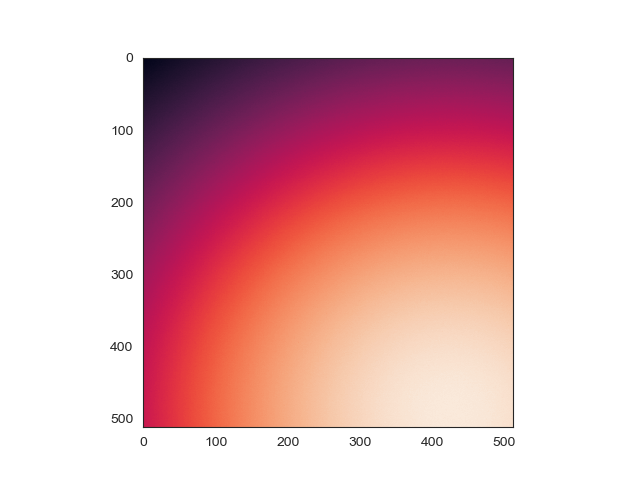

In [40]:
plt.figure()
plt.imshow(bp_final)

In [41]:
tifffile.imsave(os.path.join(output_dir, 'beamprofile.tif'), bp_final)

In [42]:
np.save(os.path.join(output_dir, 'beamprofile.npy'), bp_final)

In [43]:
c = 'c41_01'
f = '514_g100'


arr = tifffile.imread(os.path.join(data_dir, c, f + '.tif')).astype(float)

In [44]:
arr.shape

(14, 100, 512, 512)

In [39]:
cells = ['c41_repeat_02']
files = ['514_g100', '514_g500']

for c in cells:
    for f in files:
        arr = tifffile.imread(os.path.join(data_dir, c, f + '.tif')).astype(float)
        new_arr = arr
        new_arr /= bp_final
        np.save(os.path.join(output_dir, '{}_{}.npy'.format(c, f)), new_arr)

In [45]:
dfg100.mean()

1776.0279579162598

In [ ]:
dataq_dir

In [48]:
cells = ['c41_01', 'c41_02']
files = ['514_g100', '514_g500']
dfs = [dfg100, dfg500]

for c in cells:
    for df, f in zip(dfs, files):
        arr = tifffile.imread(os.path.join(data_dir, c, f + '.tif')).astype(float)
        new_arr = arr.reshape(-1, *arr.shape[2:])
        new_arr -= df.mean()
        new_arr /= bp_final
        print(c, f, new_arr.min(), new_arr.max())
        np.save(os.path.join(output_dir, '{}_{}.npy'.format(c, f)), new_arr)

c41_01 514_g100 3.3661618801178723 82885.24862219353
c41_01 514_g500 431.0473939815208 129371.2831041369
c41_02 514_g100 31.853734865931166 52917.34805067122
c41_02 514_g500 358.17657582318884 121960.07674900687


<IPython.core.display.Javascript object>


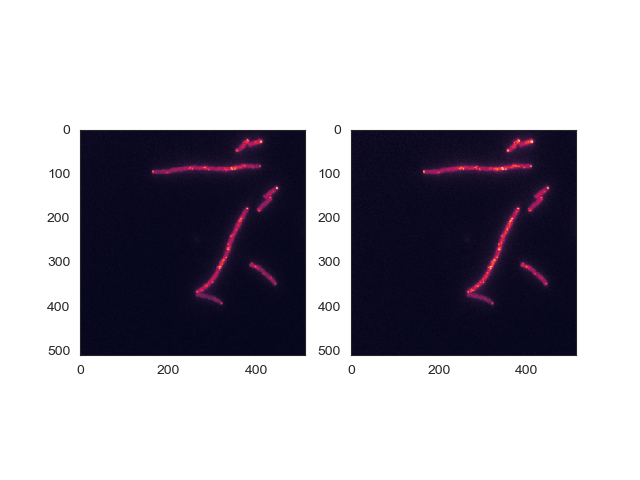

In [49]:
c = 'c41_01'
a1 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g100'))
a2 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g500'))

fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(a1)
ax2.iter_imshow(a2)
fig.display()

<IPython.core.display.Javascript object>


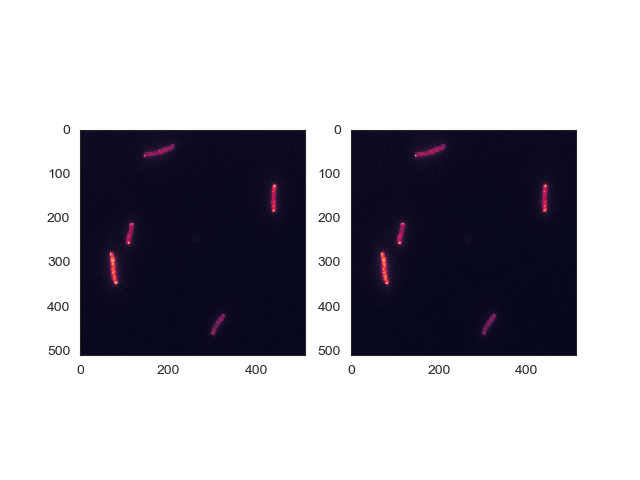

In [50]:
c = 'c41_02'
a1 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g100'))
a2 = np.load(os.path.join(output_dir, '{}_{}.npy').format(c, '514_g500'))

fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(a1)
ax2.iter_imshow(a2)
fig.display()